In [1]:
import os
import re
import requests
import uuid
from pathlib import Path
import gc

from PIL import Image
from IPython.display import display
import cv2
import pytesseract
from pdf2image import convert_from_path

import numpy as np
import torch
from transformers import AutoProcessor, AutoModelForImageTextToText, pipeline
from huggingface_hub import configure_http_backend

from langchain_community.vectorstores.faiss import FAISS
from langchain_huggingface.embeddings import HuggingFaceEmbeddings
from langchain_huggingface import HuggingFacePipeline
from langchain.prompts import PromptTemplate

import json
from tqdm import tqdm

from qwen_vl_utils import process_vision_info

import urllib3
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

In [2]:
def backend_factory() -> requests.Session:
    session = requests.Session()
    session.verify = False
    return session

configure_http_backend(backend_factory=backend_factory)

In [3]:
model_name = "unsloth/Qwen2.5-VL-7B-Instruct-unsloth-bnb-4bit"

processor = AutoProcessor.from_pretrained(model_name, use_fast=True)

model = AutoModelForImageTextToText.from_pretrained(
    model_name,
    device_map="balanced"
)

In [4]:
PDF_PATH = "/home/user/Documents/llmexam/GATE2009.pdf"  
OUTPUT_DIR = "images" 
os.makedirs(OUTPUT_DIR, exist_ok=True)

MIN_WIDTH = 50  
MIN_HEIGHT = 50  

# ----------------------------
# HELPER FUNCTIONS
# ----------------------------
def extract_question_boxes(image_cv):
    """
    Detects text boxes using OCR and identifies question segments.
    Returns a list of question bounding boxes.
    """
    custom_config = r'--oem 3 --psm 6'
    data = pytesseract.image_to_data(image_cv, config=custom_config, output_type=pytesseract.Output.DICT)

    question_boxes = []
    current_question = None
    box_start, box_end = None, None
    QUESTION_PATTERN = re.compile(r"Q(?:\.|\sNo\.?)?\s?\d+", re.IGNORECASE)

    for i in range(len(data["text"])):
        text = data["text"][i].strip()
        if not text:
            continue

        x, y, w, h = data["left"][i], data["top"][i], data["width"][i], data["height"][i]

        if QUESTION_PATTERN.match(text):
            if current_question:
                question_boxes.append((box_start, box_end))
            current_question = text
            box_start = (x, y)
            box_end = (x + w, y + h)
        elif current_question:
            box_end = (max(box_end[0], x + w), max(box_end[1], y + h))

    if current_question:
        question_boxes.append((box_start, box_end))

    return question_boxes

# ----------------------------
# PROCESSING THE PDF (MEMORY EFFICIENT WAY)
# ----------------------------
pages = convert_from_path(PDF_PATH, dpi=200)  
pdf_name = Path(PDF_PATH).stem

countQ = 0
for i, page in enumerate(pages):
    image_cv = cv2.cvtColor(np.array(page), cv2.COLOR_RGB2BGR)
    image_gray = cv2.cvtColor(image_cv, cv2.COLOR_BGR2GRAY) 
    del image_cv 

    question_boxes = extract_question_boxes(image_gray)

    for idx, (start, end) in enumerate(question_boxes, start=1):
        x1, y1 = start
        x2, y2 = end
        cropped_question = image_gray[y1:y2, x1:x2]

        h, w = cropped_question.shape[:2]
        if w < MIN_WIDTH or h < MIN_HEIGHT:
            continue  

        question_filename = f"q{countQ + 1}.jpg"
        question_path = os.path.join(OUTPUT_DIR, question_filename)
        cv2.imwrite(question_path, cropped_question)
        countQ += 1

    del image_gray 
    gc.collect() 
    torch.cuda.empty_cache() 

print(f"{countQ} questions have been extracted and saved in {OUTPUT_DIR}")

60 questions have been extracted and saved in images


In [5]:
import os
import json
import re
import gc
import torch
from PIL import Image
from tqdm import tqdm

# Folder containing images and output data list.
image_folder = "images"
output_data = []

batch_size = 10
processed_count = 0

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

def cleanup():
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()
    gc.collect()

def process_single_image(image_path, image_file):
    outputs = None
    try:
        image = Image.open(image_path).convert("RGB")
        image_key = os.path.splitext(image_file)[0]

        # Updated prompt with detailed instructions for difficulty:
        prompt_text = (
            "Analyze the question shown in the image and output exactly one line with exactly "
            "four comma-separated fields in this order: Subject, Topic, Concept, Difficulty.\n\n"
            "For Subject, output a broad academic field (e.g., Mathematics, Computer Science, Physics).\n"
            "For Topic, output a specific area under that field (e.g., Probability, Algorithms, Mechanics).\n"
            "For Concept, output a granular concept within that topic (e.g., Bayes' Theorem, QuickSort, Newton's Laws).\n\n"
            "For Difficulty, follow these steps:\n"
            "  a) Rate the question on each of the following parameters on a scale from 1 to 10:\n"
            "     - How lengthy would the solution be\n"
            "     - How hard the base concept is\n"
            "     - How many concepts are used(more means more difficult)\n"
            "     - How hard is the language of the question\n"
            "  b) Compute the average of these four ratings.\n"
            "  c) If the average is less than 6, the difficulty is Easy; if greater than 8, it is Hard; otherwise, Medium.\n\n"
            "Do not output any additional text. Your output must be exactly one line formatted as:\n"
            "Subject, Topic, Concept, Difficulty\n\n"
            "Examples:\n"
            "Mathematics, Probability, Bayes' Theorem, Hard\n"
            "Computer Science, Algorithms, QuickSort, Medium\n"
            "Physics, Mechanics, Newton's Laws, Easy\n\n"
            "Now, analyze the image and return the four fields in the same format."
        )

        conversations = [
            [
                {
                    "role": "user",
                    "content": [
                        {"type": "text", "text": prompt_text},
                        {"type": "image", "image": image}
                    ]
                }
            ]
        ]

        # Generate prompt text.
        text_list = processor.apply_chat_template(
            conversations, tokenize=False, add_generation_prompt=True
        )
        text = text_list if isinstance(text_list, str) else text_list[0]

        # Process vision inputs.
        image_inputs, _ = process_vision_info(conversations)

        # Prepare inputs for the model.
        inputs = processor(
            text=[text], images=image_inputs, return_tensors="pt", padding=True
        ).to(model.device, dtype=torch.float16)

        with torch.no_grad():
            outputs = model.generate(**inputs, max_new_tokens=100)
            generated_text = processor.batch_decode(outputs, skip_special_tokens=True)[0]

        # Clean up generated text to extract exactly one line.
        cleaned_text = generated_text.split("assistant")[-1].strip() if "assistant" in generated_text else generated_text.strip()
        cleaned_text = re.sub(r'\n', ' ', cleaned_text).strip()

        # Parse the comma-separated values.
        parts = [part.strip() for part in cleaned_text.split(',')]
        if len(parts) >= 4:
            subject, topic, concept, difficulty = parts[:4]
        else:
            subject, topic, concept, difficulty = (parts + ["Unknown"] * 4)[:4]

        output_data.append({
            "id": image_key,
            "subject": subject,
            "topic": topic,
            "concept": concept,
            "difficulty": difficulty
        })

    except Exception as e:
        print(f"Error processing {image_file}: {e}")
    finally:
        del image, image_inputs, inputs, text_list, text, conversations
        if outputs is not None:
            del outputs
        cleanup()

# Process .jpg files.
image_files = [f for f in os.listdir(image_folder) if f.endswith(".jpg")]

for image_file in tqdm(image_files, desc="Processing Images", unit="img"):
    image_path = os.path.join(image_folder, image_file)
    process_single_image(image_path, image_file)
    processed_count += 1
    if processed_count % batch_size == 0:
        cleanup()

# Save the results to a JSON file.
output_json_path = "output_tags.json"
with open(output_json_path, "w", encoding="utf-8") as json_file:
    json.dump(output_data, json_file, indent=4, ensure_ascii=False)

Processing Images:   0%|          | 0/60 [00:00<?, ?img/s]

Processing Images:  32%|███▏      | 19/60 [00:41<01:14,  1.82s/img]

Error processing q60.jpg: CUDA out of memory. Tried to allocate 6.45 GiB. GPU 0 has a total capacity of 15.81 GiB of which 3.52 GiB is free. Including non-PyTorch memory, this process has 11.00 GiB memory in use. Of the allocated memory 9.54 GiB is allocated by PyTorch, and 119.57 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Processing Images: 100%|██████████| 60/60 [01:55<00:00,  1.93s/img]


In [6]:
embeddings = HuggingFaceEmbeddings(model_name="thenlper/gte-large")

with open("output_tags.json", "r", encoding="utf-8") as json_file:
    image_data = json.load(json_file)

def compute_weighted_embedding(tags, embeddings, weights):
    tag_embeddings = np.array([embeddings.embed_query(tag) for tag in tags])  
    weighted_embedding = np.sum(weights[:, None] * tag_embeddings, axis=0)  
    return weighted_embedding / np.sum(weights)  

first_entry = image_data[0]
first_embedding = compute_weighted_embedding(
    [first_entry["subject"], first_entry["topic"], first_entry["concept"], first_entry["difficulty"]],
    embeddings,
    np.array([0.5, 0.3, 0.2, 0])
)

vector_db = FAISS.from_embeddings(
    text_embeddings=[("dummy", first_embedding)],  
    embedding=embeddings,
    metadatas=[{
        "subject": first_entry["subject"],
        "topic": first_entry["topic"],
        "concept": first_entry["concept"],
        "difficulty": first_entry["difficulty"],
        "image_path": os.path.join("images", f"{first_entry['id']}.jpg")
    }],
    ids=[str(uuid.uuid4())]
)

for entry in image_data[1:]:
    combined_embedding = compute_weighted_embedding(
        [entry["subject"], entry["topic"], entry["concept"], entry["difficulty"]],
        embeddings,
        np.array([0.5, 0.3, 0.2, 0])
    )
    
    vector_db.add_embeddings(
        text_embeddings=[("dummy", combined_embedding)], 
        metadatas=[{
            "subject": entry["subject"],
            "topic": entry["topic"],
            "concept": entry["concept"],
            "difficulty": entry["difficulty"],
            "image_path": os.path.join("images", f"{entry['id']}.jpg")
        }],
        ids=[str(uuid.uuid4())]
    )

print("✅ All images and weighted embeddings added to FAISS successfully!")

✅ All images and weighted embeddings added to FAISS successfully!


In [7]:
index_path = "faiss_index"

vector_db.save_local(index_path)
print(f"💾 FAISS index saved at '{index_path}'.")

vector_db = FAISS.load_local(index_path, embeddings=embeddings, allow_dangerous_deserialization=True)
print("🔄 FAISS index loaded successfully.")

print("✅ FAISS index saved and reloaded.")

💾 FAISS index saved at 'faiss_index'.
🔄 FAISS index loaded successfully.
✅ FAISS index saved and reloaded.


In [8]:
system_prompt = '''You are a keyword extractor. The user will provide a query and request a specific number of questions on some topic.  
Your task is to output the numeber of questions and the topic, ensuring that the output strictly follows these guidelines:  
1. Output should be a Python list containing 'n' elements, where 'n' is the (number of topics identified + 1 (or 2 sometimes when you can find one of the three words easy, medium or hard in the user input)).  
2. The first element should be an integer which signifies the number of questions user has asked for and second element onwards should be the topics identified and the last element should be the difficulty if prompted. 
3. Do not add any additional text, explanations, or formatting—only return the list as told.  
4. Ensure the output strictly adheres to this format:  
   ["<number_of_questions>", "topic_1", "topic_2", ...., "topic_n", "<difficulty>"]
where number of questions and topic and diffculty is directly derived from the user's input.
Example:
User input: Extract 3 medium level questions based on the topics data structures and algorithms.
Expected output: 
["3", "data structures", "algorithms", "Medium"]


REMEMBER, YOU HAVE TO ONLY GIVE THE LIST OF TOPICS AS OUTPUT, DO NOT START YAPPING. JUST DO AS ASKED TO. ALSO MAKE SURE THAT YOU ONLY GENERATE TOPICS THAT ARE EQUAL TO THE NUMBER ASKED BY THE USER. 
THE NUMBER OF TOPICS GENERATED SHOULD NEITHER BE LESS NOR MORE THAN THE NUMBER ASKED BY THE USER.
'''

user_prompt_template = PromptTemplate(
    input_variables=["user_input"],
    template="<|system|>{system_prompt}<|user|>{user_input}<|end|>"
)

pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=processor.tokenizer,
    device_map="balanced",
    max_new_tokens=100,
    return_full_text=False
)

llm = HuggingFacePipeline(pipeline=pipe)

user_input = "Generate 2 hard questions from the topics computer networks."
formatted_prompt = user_prompt_template.format(
    system_prompt=system_prompt,
    user_input=user_input
)

response = llm.invoke(formatted_prompt)

match = re.search(r'<\|system\|>(.*?)<\|end\|>$', response, re.DOTALL)
if match:
    extracted_list = match.group(1).strip()
    print("Parsed response:")
    print(extracted_list)
else:
    print("No list found between <|system|> and <|end|> tags.")

Device set to use cuda:0
The model 'Qwen2_5_VLForConditionalGeneration' is not supported for text-generation. Supported models are ['AriaTextForCausalLM', 'BambaForCausalLM', 'BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CohereForCausalLM', 'Cohere2ForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'DbrxForCausalLM', 'DiffLlamaForCausalLM', 'ElectraForCausalLM', 'Emu3ForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'FalconMambaForCausalLM', 'FuyuForCausalLM', 'GemmaForCausalLM', 'Gemma2ForCausalLM', 'GitForCausalLM', 'GlmForCausalLM', 'GotOcr2ForConditionalGeneration', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoForCausalLM', 'GPTNeoXForCausalLM', 'GPTNeoXJapaneseForCausalLM', 'GPTJForCausalLM', 'G

Parsed response:
["2", "computer networks", "hard"]


In [9]:
import ast

extracted_list = ast.literal_eval(extracted_list)

print("Parsed response as list:")
print(extracted_list)

Parsed response as list:
['2', 'computer networks', 'hard']


⚠️ No items found with desired difficulty: Hard

Showing 6 items with next closest difficulty: Medium...


🔍 Query: computer networks

1. Subject: Networking
   Topic: Networking Protocols
   Concept: Sliding Window Protocol
   Difficulty: Medium

🔷 Image Path: images/q58.jpg
────────────────────────────────────────


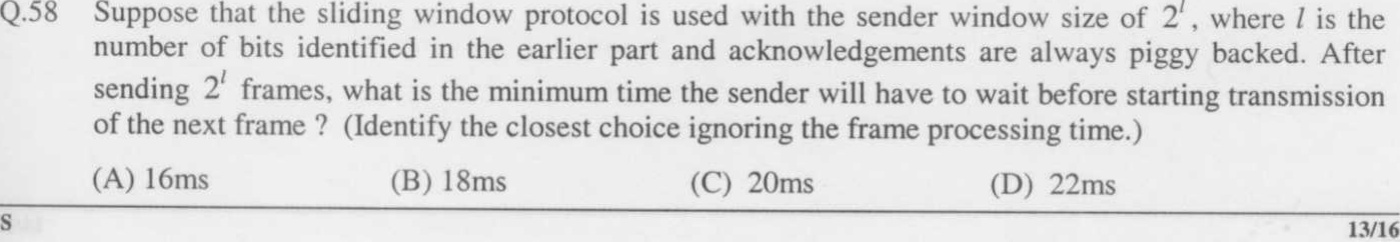


2. Subject: Computer Science
   Topic: Networking
   Concept: Sequence Number Generation
   Difficulty: Medium

🔷 Image Path: images/q47.jpg
────────────────────────────────────────


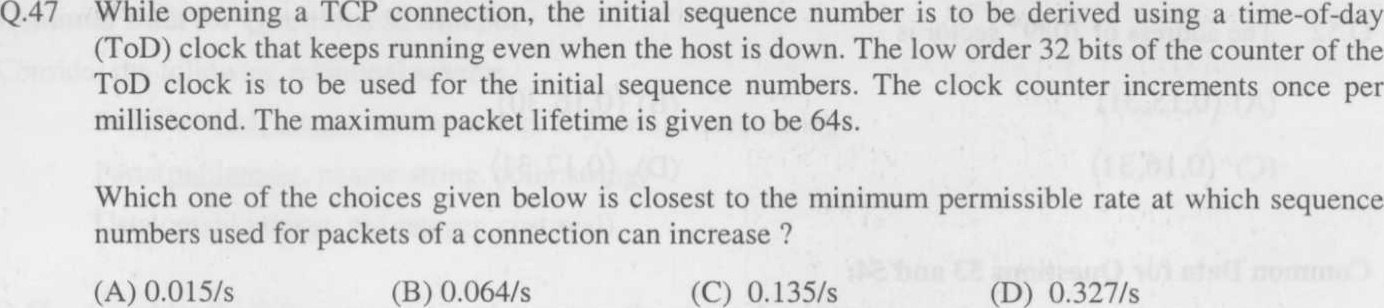

In [10]:
k = int(extracted_list[0])
topics = extracted_list[1:-1]
difficulty = extracted_list[-1]

topic_embeddings = embeddings.embed_documents(topics)
query_vector = np.sum(topic_embeddings, axis=0)  

difficulty_order = {"Easy": 0, "Medium": 1, "Hard": 2}


def retrieve_similar_images(query_vector, query_text, vector_db, top_k, desired_difficulty):
    raw_results = vector_db.similarity_search_by_vector(query_vector, k=top_k * 3)
    
    desired_diff_norm = desired_difficulty.capitalize()
    desired_num = difficulty_order.get(desired_diff_norm, 1)
    
    group_desired = []
    groups_other = {}  
    for res in raw_results:
        diff = res.metadata.get('difficulty', '').strip()
        if not diff:
            continue
        diff_clean = diff.capitalize()
        if diff_clean == desired_diff_norm:
            group_desired.append(res)
        else:
            groups_other.setdefault(diff_clean, []).append(res)
    
    final_results = []
    
    if len(group_desired) >= top_k:
        final_results = group_desired[:top_k]
        print(f"Found {len(final_results)} items with desired difficulty: {desired_diff_norm}.")
    else:
        final_results.extend(group_desired)
        missing = top_k - len(group_desired)
        if len(group_desired) == 0:
            print(f"⚠️ No items found with desired difficulty: {desired_diff_norm}\n")
        else:
            print(f"Only found {len(group_desired)} items with desired difficulty: {desired_diff_norm}.\n")
        
        if groups_other:
            sorted_diff_keys = sorted(
                groups_other.keys(),
                key=lambda d: abs(difficulty_order.get(d, 1) - desired_num)
            )
            next_diff = sorted_diff_keys[0]
            next_items = groups_other[next_diff]
            print(f"Showing {len(next_items)} items with next closest difficulty: {next_diff}...\n")
            final_results.extend(next_items[:missing])
        else:
            print("No items found with any other difficulty level.")
    
    retrieved_metadata = [res.metadata for res in final_results]
    print(f"\n🔍 Query: {query_text}\n")
    
    for idx, metadata in enumerate(retrieved_metadata, start=1):
        image_path = metadata.get('image_path', 'N/A')
        subject = metadata.get('subject', 'N/A')
        topic = metadata.get('topic', 'N/A')
        concept = metadata.get('concept', 'N/A')
        diff_str = metadata.get('difficulty', 'N/A')
        print(f"{idx}. Subject: {subject}\n   Topic: {topic}\n   Concept: {concept}\n   Difficulty: {diff_str}\n\n🔷 Image Path: {image_path}\n" + "─" * 40)
        
        try:
            display(Image.open(image_path))
            print("=" * 70, "\n")
        except Exception as e:
            print(f"⚠️ Unable to load image: {e}")
    
    return retrieved_metadata


retrieved_data = retrieve_similar_images(query_vector, ", ".join(topics), vector_db, k, difficulty)

In [11]:
import shutil
retrieved_images_dir = "retrieved_images"
os.makedirs(retrieved_images_dir, exist_ok=True)  # Create the directory if it doesn't exist

for metadata in retrieved_data:
    image_path = metadata.get("image_path", "N/A")
    if os.path.exists(image_path):
        shutil.copy(image_path, os.path.join(retrieved_images_dir, os.path.basename(image_path)))

In [12]:
# Load model directly
from transformers import AutoProcessor, AutoModelForImageTextToText

processor = AutoProcessor.from_pretrained("ds4sd/SmolDocling-256M-preview")
model = AutoModelForImageTextToText.from_pretrained("ds4sd/SmolDocling-256M-preview")

In [14]:
print(retrieved_data)

[{'subject': 'Networking', 'topic': 'Networking Protocols', 'concept': 'Sliding Window Protocol', 'difficulty': 'Medium', 'image_path': 'images/q58.jpg'}, {'subject': 'Computer Science', 'topic': 'Networking', 'concept': 'Sequence Number Generation', 'difficulty': 'Medium', 'image_path': 'images/q47.jpg'}]


In [21]:
def extract_text_from_image(image_path):
    try:
        # Check if file exists
        if not os.path.exists(image_path):
            return f"Error: Image file not found at {image_path}"
            
        # Open and process the image
        image = Image.open(image_path).convert('RGB')
        
        # Resize image to a standard size (try 512x512 since that's what processor output suggests)
        target_size = (512, 512)
        image = image.resize(target_size, Image.Resampling.LANCZOS)
        
        # Process the image with the processor
        inputs = processor(images=image, return_tensors="pt")
        
        # Debug: Check input shape
        pixel_values = inputs['pixel_values']
        print(f"Debug: Input pixel_values shape for {image_path}: {pixel_values.shape}")
        
        # Ensure we're working with a single image tensor
        if len(pixel_values.shape) > 4:  # If shape is [1, patches, 3, H, W]
            # Take the first patch or flatten if that's the issue
            pixel_values = pixel_values[:, 0, :, :, :]  # Take first patch
            print(f"Debug: Adjusted pixel_values shape: {pixel_values.shape}")
        
        # Generate text
        with torch.no_grad():
            outputs = model.generate(
                pixel_values=pixel_values,
                max_length=512,
            )
        
        # Debug: Check output shape
        print(f"Debug: Output shape for {image_path}: {outputs.shape}")
        
        # Decode the generated text
        extracted_text = processor.decode(outputs[0], skip_special_tokens=True)
        
        return extracted_text
    
    except FileNotFoundError:
        return f"Error: Image file not found at {image_path}"
    except Exception as e:
        return f"Error processing image {image_path}: {str(e)}"

# Process each image in the list and store results
results = []
for metadata in retrieved_data:
    image_path = metadata['image_path']
    extracted_text = extract_text_from_image(image_path)
    
    # Create a result dictionary with original metadata plus extracted text
    result = metadata.copy()
    result['extracted_text'] = extracted_text
    results.append(result)

# Print results
for result in results:
    print(f"\nImage: {result['image_path']}")
    print(f"Subject: {result['subject']}")
    print(f"Topic: {result['topic']}")
    print(f"Concept: {result['concept']}")
    print(f"Difficulty: {result['difficulty']}")
    print(f"Extracted Text: {result['extracted_text']}")

Debug: Input pixel_values shape for images/q58.jpg: torch.Size([1, 17, 3, 512, 512])
Debug: Adjusted pixel_values shape: torch.Size([1, 3, 512, 512])
Debug: Input pixel_values shape for images/q47.jpg: torch.Size([1, 17, 3, 512, 512])
Debug: Adjusted pixel_values shape: torch.Size([1, 3, 512, 512])

Image: images/q58.jpg
Subject: Networking
Topic: Networking Protocols
Concept: Sliding Window Protocol
Difficulty: Medium
Extracted Text: Error processing image images/q58.jpg: not enough values to unpack (expected 5, got 4)

Image: images/q47.jpg
Subject: Computer Science
Topic: Networking
Concept: Sequence Number Generation
Difficulty: Medium
Extracted Text: Error processing image images/q47.jpg: not enough values to unpack (expected 5, got 4)


In [23]:
import torch
from transformers import AutoProcessor, AutoModelForVision2Seq
from transformers.image_utils import load_image

# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load model and processor
processor = AutoProcessor.from_pretrained("ds4sd/SmolDocling-256M-preview")
model = AutoModelForVision2Seq.from_pretrained("ds4sd/SmolDocling-256M-preview").to(device)

# Load an image
image = load_image("/home/user/Documents/LLMExam/retrieved_images/q47.jpg")

# Prepare input
messages = [{"role": "user", "content": [{"type": "image"}, {"type": "text", "text": "Convert this page"}]}]
prompt = processor.apply_chat_template(messages, add_generation_prompt=True)
inputs = processor(text=prompt, images=[image], return_tensors="pt").to(device)

# Generate DocTags output
outputs = model.generate(**inputs, max_new_tokens=8192)
doctags = processor.batch_decode(outputs, skip_special_tokens=False)[0]
print(doctags)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


<|im_start|>User:<fake_token_around_image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><fake_token_around_image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><fake_token_around_imag

In [30]:
for metadata in retrieved_data:
    image_path = metadata['image_path']
    image = load_image(image_path)
    messages = [{"role": "user", "content": [{"type": "image"}, {"type": "text", "text": "Extract the text from this image as plain text"}]}]
    prompt = processor.apply_chat_template(messages, add_generation_prompt=True)
    inputs = processor(text=prompt, images=[image], return_tensors="pt").to(device)

    # Generate output
    outputs = model.generate(**inputs, max_new_tokens=8192)
    raw_output = processor.batch_decode(outputs, skip_special_tokens=False)[0]

    # Simple post-processing to remove DocTags and keep plain text
    # This assumes DocTags are enclosed in <...> or similar markup; adjust based on actual output
    plain_text = ""
    in_tag = False
    for char in raw_output:
        if char == '<':
            in_tag = True
        elif char == '>':
            in_tag = False
        elif not in_tag:
            plain_text += char

    # Print the plain text
    print(plain_text.strip())

User:

Extract the text from this image as plain text
Assistant: image:  Q.58 Suppose that the sliding window protocol is used with the sender window size of 2', where I is the number of bits identified in the earlier part and acknowledgements are always piggy backed. After sending 2' frames, what is the minimum time the sender will have to wait before starting transmission of the next frame ? (Identify the closest choice ignoring the frame processing time.) (A) 16ms (B) 18ms (C) 20ms (D) 22ms s 13/16
User:

Extract the text from this image as plain text
Assistant: image: (ToD clock is to be used for the initial sequence numbers. The clock counter increments once per millisecond. The maximum packet lifetime is given to be 64s.
